In [ ]:
pip install hexy>=1.4.3

In [ ]:
pip install mock>=1.0.1

In [ ]:
pip install pytest==4.6.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 230 kB 5.0 MB/s 
  Attempting uninstall: pluggy
    Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Attempting uninstall: pytest
    Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
pip install -i https://test.pypi.org/simple/ htm.core

Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 5.3 MB/s 


In [ ]:
import numpy as np
import PIL as pil
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sb
from htm.bindings.encoders import ScalarEncoder
from htm.bindings.encoders import ScalarEncoderParameters
import htm.bindings.encoders
from htm.bindings.sdr import SDR
from htm.algorithms import SpatialPooler, TemporalMemory

In [ ]:
img = pil.Image.open("/content/image640x426.jpg")

In [ ]:
img_arr = np.asarray(img)

In [ ]:
img_arr

array([[[181, 194, 203],
        [183, 196, 205],
        [187, 197, 207],
        ...,
        [  0,  13,  91],
        [  0,  12,  90],
        [  0,  11,  90]],

       [[185, 198, 207],
        [188, 201, 210],
        [194, 204, 214],
        ...,
        [  0,  15,  93],
        [  0,  14,  92],
        [  0,  14,  92]],

       [[183, 196, 205],
        [188, 201, 210],
        [195, 205, 215],
        ...,
        [  0,  19,  95],
        [  0,  18,  94],
        [  0,  16,  92]],

       ...,

       [[132, 152, 140],
        [ 65,  85,  73],
        [ 61,  83,  70],
        ...,
        [  3,  24,  43],
        [  2,  20,  40],
        [  0,  17,  37]],

       [[ 71,  89,  75],
        [100, 121, 106],
        [123, 146, 130],
        ...,
        [  2,  23,  42],
        [  2,  20,  40],
        [  0,  16,  36]],

       [[128, 144, 131],
        [170, 188, 174],
        [168, 191, 175],
        ...,
        [  3,  21,  41],
        [  1,  19,  39],
        [  0,  16,  36]]

In [ ]:
img_arr.shape

(427, 640, 3)

In [ ]:
img_arr_flatten = img_arr.flatten()

In [ ]:
img_arr_flatten

array([181, 194, 203, ...,   0,  16,  36], dtype=uint8)

In [ ]:
img_arr_flatten.shape

(819840,)

In [ ]:
np.min(img_arr_flatten)

0

## Scaler Encoder

In [ ]:
MIN_VAL = np.min(img_arr_flatten)
MAX_VAL = np.max(img_arr_flatten)
NUM_ACTIVE_BITS = 256
NUM_BUCKETS = 100
SIZE = 1024

In [ ]:
parameters = ScalarEncoderParameters()

In [ ]:
parameters.activeBits = NUM_ACTIVE_BITS
parameters.minimum = MIN_VAL
parameters.maximum = MAX_VAL
parameters.size = SIZE

In [ ]:
enc = ScalarEncoder(parameters)

In [ ]:
bin_encoded = []

for i in range(img_arr_flatten.shape[0]):
    res = enc.encode(int(img_arr_flatten[i]))
    bin_encoded.append(res.dense)

bin_encoded = np.array(bin_encoded)

In [ ]:
bin_encoded

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [ ]:
bin_encoded.shape

(819840, 1024)

In [ ]:
help(htm.bindings.encoders)

Help on module htm.bindings.encoders in htm.bindings:

NAME
    htm.bindings.encoders - Encoders convert values into sparse distributed representation.

DESCRIPTION
    There are several critical properties which all encoders must have:
    
        1) Semantic similarity:  Similar inputs should have high overlap.  Overlap
        decreases smoothly as inputs become less similar.  Dissimilar inputs have
        very low overlap so that the output representations are not easily confused.
    
        2) Stability:  The representation for an input does not change during the
        lifetime of the encoder.
    
        3) Sparsity: The output SDR should have a similar sparsity for all inputs and
        have enough active bits to handle noise and subsampling.
    
    Reference: https://arxiv.org/pdf/1602.05925.pdf
    
    
    CategoryEncoders:
    
        To encode categories of input, make a ScalarEncoder or a Random Distributed
    Scalar Encoder (RDSE), and set the parameter categ

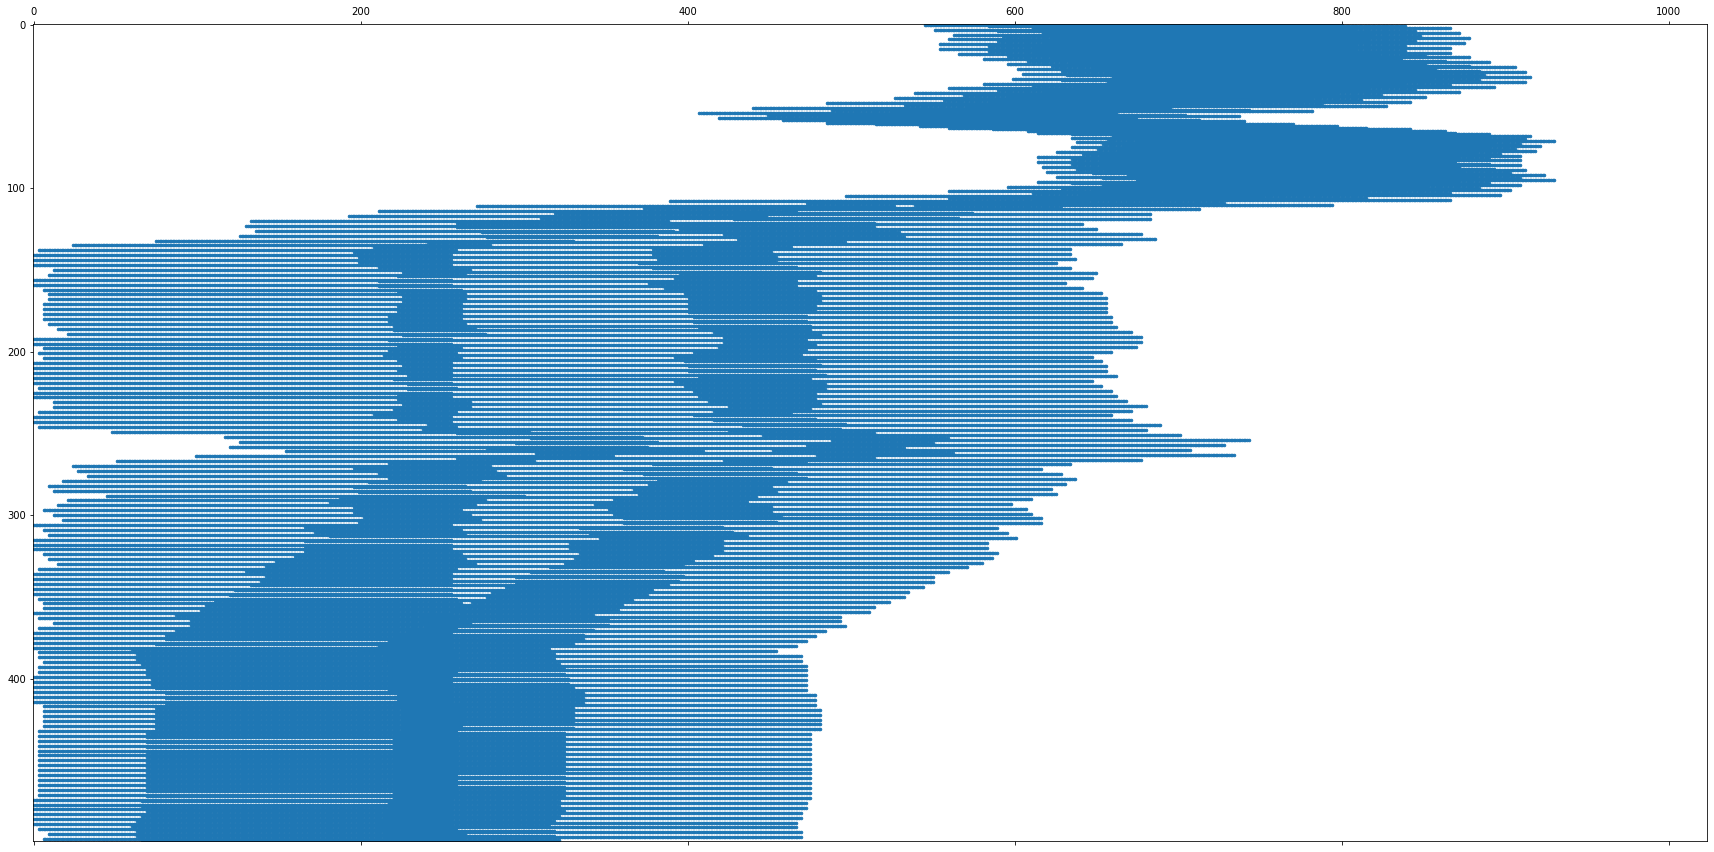

In [ ]:
plt.figure(figsize=(30, 50))
a = sparse.csr_matrix(bin_encoded[:500, :])

plt.spy(a, marker='.', markersize=5)
plt.show()

In [ ]:
sd = SDR(dimensions=bin_encoded.shape[1])
sd.dense = bin_encoded[0]

In [ ]:
sd.dense

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

## Spatial Pooler

In [ ]:
help(htm.algorithms.SpatialPooler)

Help on class SpatialPooler in module htm.bindings.algorithms:

class SpatialPooler(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      SpatialPooler
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getstate__(...)
 |      __getstate__(self: htm.bindings.algorithms.SpatialPooler) -> bytes
 |  
 |  __init__(...)
 |      __init__(self: htm.bindings.algorithms.SpatialPooler, inputDimensions: List[int] = [32, 32], columnDimensions: List[int] = [64, 64], potentialRadius: int = 16, potentialPct: float = 0.5, globalInhibition: bool = False, localAreaDensity: float = 0.019999999552965164, numActiveColumnsPerInhArea: int = 0, stimulusThreshold: int = 0, synPermInactiveDec: float = 0.01, synPermActiveInc: float = 0.1, synPermConnected: float = 0.1, minPctOverlapDutyCycle: float = 0.001, dutyCyclePeriod: int = 1000, boostStrength: float = 0.0, seed: int = 1, spVerbosity: int = 0, wrapAround: bool = True) -> None
 |    

In [ ]:
help(htm.bindings.sdr.SDR)

Help on class SDR in module htm.bindings.sdr:

class SDR(pybind11_builtins.pybind11_object)
 |  Sparse Distributed Representation
 |  
 |  This class manages the specification and momentary value of a Sparse Distributed
 |  Representation (SDR).  An SDR is a group of boolean values which represent the
 |  state of a group of neurons or their associated processes.
 |  
 |  SDR's have three commonly used data formats which are:
 |  *   dense
 |  *   sparse
 |  *   coordinates
 |  The SDR class has three magic properties, one for each of these data formats.
 |  These properties are the primary way of accessing the SDR's data.  When these
 |  properties are read from, the data is automatically converted to the requested
 |  format and is cached so getting a value in one format many times incurs no extra
 |  performance cost.  Assigning to the SDR via any one of these properties clears
 |  the cached values and causes them to be recomputed as needed.
 |  
 |  Example usage:
 |      # Make a

In [ ]:
INPUT_DIMENSIONS = SIZE
COLUMN_DIMENSIONS = 2048
GLOBAL_INHIBITION = True
POTENTIAL_RADIUS = SIZE

In [ ]:
sp = SpatialPooler(inputDimensions = [SIZE,], 
                   columnDimensions = [COLUMN_DIMENSIONS,], 
                   potentialRadius = POTENTIAL_RADIUS, 
                   potentialPct = 0.5, 
                   globalInhibition = GLOBAL_INHIBITION, 
                   localAreaDensity = 0.019999999552965164, 
                   numActiveColumnsPerInhArea = 0, 
                   stimulusThreshold = 0, 
                   synPermInactiveDec = 0.01, 
                   synPermActiveInc = 0.1, 
                   synPermConnected = 0.1,
                   minPctOverlapDutyCycle = 0.001, 
                   dutyCyclePeriod = 1000, 
                   boostStrength = 0.0, 
                   seed = 1, 
                   spVerbosity = 0, 
                   wrapAround = True)

In [ ]:
sp.getNumInputs()

1024

In [ ]:
sp.getNumColumns()

2048

In [ ]:
sp_info = sp.compute(input=sd, learn=True, output=SDR(sp.getNumColumns()))

In [ ]:
sp_info

array([63, 56, 71, ..., 61, 69, 53], dtype=uint16)

In [ ]:
sp_info.shape

(2048,)

In [ ]:
sp_info[:100]

array([63, 56, 71, 53, 63, 59, 71, 57, 65, 60, 65, 65, 64, 65, 49, 73, 62,
       66, 67, 70, 64, 71, 64, 68, 65, 63, 63, 66, 72, 61, 78, 65, 60, 71,
       61, 66, 58, 61, 67, 66, 64, 52, 60, 67, 71, 55, 68, 60, 66, 73, 59,
       74, 60, 67, 66, 70, 72, 65, 63, 63, 84, 60, 64, 65, 53, 75, 64, 59,
       66, 58, 63, 69, 73, 56, 62, 75, 63, 55, 64, 72, 69, 59, 66, 64, 56,
       65, 64, 54, 62, 67, 73, 63, 68, 63, 65, 62, 74, 63, 60, 60],
      dtype=uint16)

In [ ]:
sp_info_all = []

for i in range(bin_encoded.shape[0]):
    sd = SDR(dimensions=sp.getNumInputs())
    sd.dense = bin_encoded[i]

    sp_info = sp.compute(input=sd, learn=True, output=SDR(sp.getNumColumns()))
    
    sp_info_all.append(sp_info)

sp_info_all = np.array(sp_info_all)

In [ ]:
sp_info_all

array([[ 63,  56,  71, ...,  61,  69,  53],
       [ 61,  57,  67, ...,  61,  71,  54],
       [ 62,  57,  69, ...,  64,  68,  53],
       ...,
       [ 65,  56,  57, ...,  61, 140,  98],
       [ 64,  56,  53, ...,  57, 119, 120],
       [ 62,  54,  59, ...,  64, 101, 131]], dtype=uint16)

In [ ]:
sp_info_all.shape

(819840, 2048)

## Temporal Memory

In [ ]:
help(htm.algorithms.TemporalMemory)

Help on class TemporalMemory in module htm.bindings.algorithms:

class TemporalMemory(pybind11_builtins.pybind11_object)
 |  Temporal Memory implementation in C++.
 |  
 |  Example usage:
 |      TODO
 |  
 |  Method resolution order:
 |      TemporalMemory
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getstate__(...)
 |      __getstate__(self: htm.bindings.algorithms.TemporalMemory) -> bytes
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: htm.bindings.algorithms.TemporalMemory) -> None
 |      
 |      2. __init__(self: htm.bindings.algorithms.TemporalMemory, columnDimensions: List[int], cellsPerColumn: int = 32, activationThreshold: int = 13, initialPermanence: float = 0.21, connectedPermanence: float = 0.5, minThreshold: int = 10, maxNewSynapseCount: int = 20, permanenceIncrement: float = 0.1, permanenceDecrement: float = 0.1, predictedSegmentDecreme

In [ ]:
tm = TemporalMemory(columnDimensions = [sp.getNumColumns()], 
                    cellsPerColumn = 32, 
                    activationThreshold = 13, 
                    initialPermanence = 0.21, 
                    connectedPermanence = 0.5, 
                    minThreshold = 10, 
                    maxNewSynapseCount = 20, 
                    permanenceIncrement = 0.1, 
                    permanenceDecrement = 0.1, 
                    predictedSegmentDecrement = 0.0, 
                    seed = 42, 
                    maxSegmentsPerCell = 255, 
                    maxSynapsesPerSegment = 255, 
                    checkInputs = True, 
                    externalPredictiveInputs = 0)

In [ ]:
sd1 = SDR(dimensions=sp.getNumColumns())
sd1.dense = sp_info_all[0]

In [ ]:
tm.compute(activeColumns=sd1, learn=True)

In [ ]:
tm.getActiveCells().dense

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int8)

In [ ]:
tm_info_all = []

for i in range(bin_encoded.shape[0]):
    sd1 = SDR(dimensions=sp.getNumColumns())
    sd1.dense = sp_info_all[i]

    tm_info = tm.compute(activeColumns=sd1, learn=True)
    
    tm_info_all.append(tm_info)

tm_info_all = np.array(tm_info_all)

In [ ]:
tm_info_all

array([None, None, None, ..., None, None, None], dtype=object)

In [ ]:
tm_info_all.shape

(819840,)